In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sdof model approximating x axis model from 10.1016/j.mechatronics.2017.09.002
# all calculations use mks units, convert to mm and mm/s when plotting
# speed, acceleration and Marlin-jerk are taken from the Prusa MK3S presets in PrusaSlicer (.1 m/s, 1 m/s², 0.008 m/s)

omega = 33.5 * 2 * np.pi # angular eigenfrequency
omega2 = omega**2
D = 0.04 # damping ratio
period = 2 * np.pi / omega # undamped
dPeriod = period / np.sqrt(1-D**2) # damped

In [3]:
period

0.029850746268656716

In [4]:
# harmonic oscillator with base excitation

# x: displacement of x carriage
# u: setpoint for x carriage displacement (base (motor) position)
# m: mass of x carriage
# d: damping of x carriage belt
# x: stiffness of x carriage belt

# ODE: m x'' + d x' + k x = d u' + k u
#  => x'' = d/m u' + k/m u - d/m x' - k/m x
#  x'' = 2 D omega u' + omega**2 u - 2 D omega x' - omega**2 x

def f(t, X, fu):
    # X has two components: X=[x, x'].
    x, xdot = X[0], X[1]
    [u, udot] = fu(t)
    xdotdot = omega2*(u-x) + 2*D*omega*(udot-xdot)
    # return X'=[x', x''].
    return [xdot, xdotdot]

In [5]:
def plotfun(fu, X0, title):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10),sharex=True)

    tspan = [0., 0.4]
    t_eval = np.linspace(tspan[0], tspan[1], 800)

    # simulate the system and evaluate X on the given times.
    sol  = spi.solve_ivp(lambda t,X:f(t,X,fu) , tspan, X0, t_eval=t_eval, method='DOP853',rtol=1e-6)

    # target position
    u_mm = [1000*fu(t)[0] for t in t_eval]
    udot_mms = [1000*fu(t)[1] for t in t_eval]

    # plot the solution
    ax[0].plot(t_eval, 1000*sol.y[0,:], '-', label=f'x(t)  in mm')
    ax[0].plot(t_eval, u_mm, '-', label=f'u(t)  in mm')
    #ax[0].set_ylabel(" x(t), u(t)")
    ax2=ax[0].twinx()
    # different y-axis for velocity
    ax2.plot(t_eval, udot_mms, '-', label=f"u'(t)  in mm/s", color='tab:green')
    #ax2.set_ylabel("u'(t)")
    ax[1].set_xlabel("Time in seconds")
    ax[0].legend(loc=6)
    ax2.legend(loc=7)
    # plot error in second plot
    ax[1].plot(t_eval, 1000*sol.y[0,:] - u_mm, '-', label=f'x(t) - u(t)  in mm', color='black')
    ax[1].legend()
    plt.title(title)

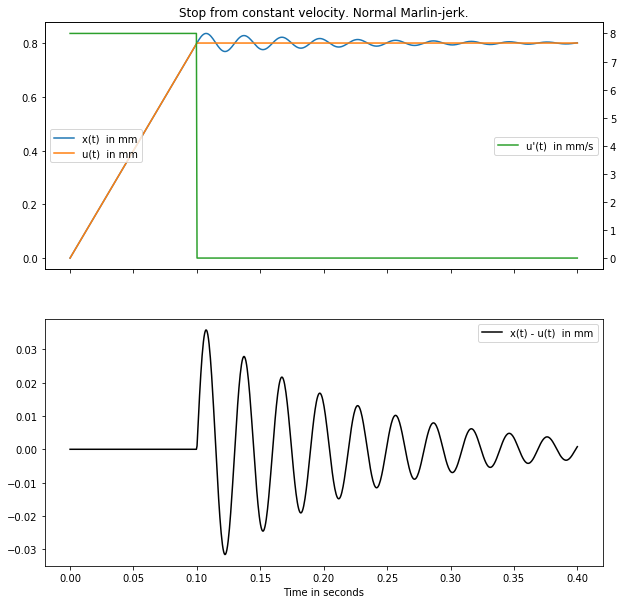

In [6]:
u0 = 0
v0 = 0.008
T = .1
def fu(t):
    # constant speed v, then stop at t = T
    if t<T:
        return [u0+v0*t, v0]
    else:
        return [u0+v0*T, 0]

plotfun(fu, [0.,v0], 'Stop from constant velocity. Normal Marlin-jerk.')

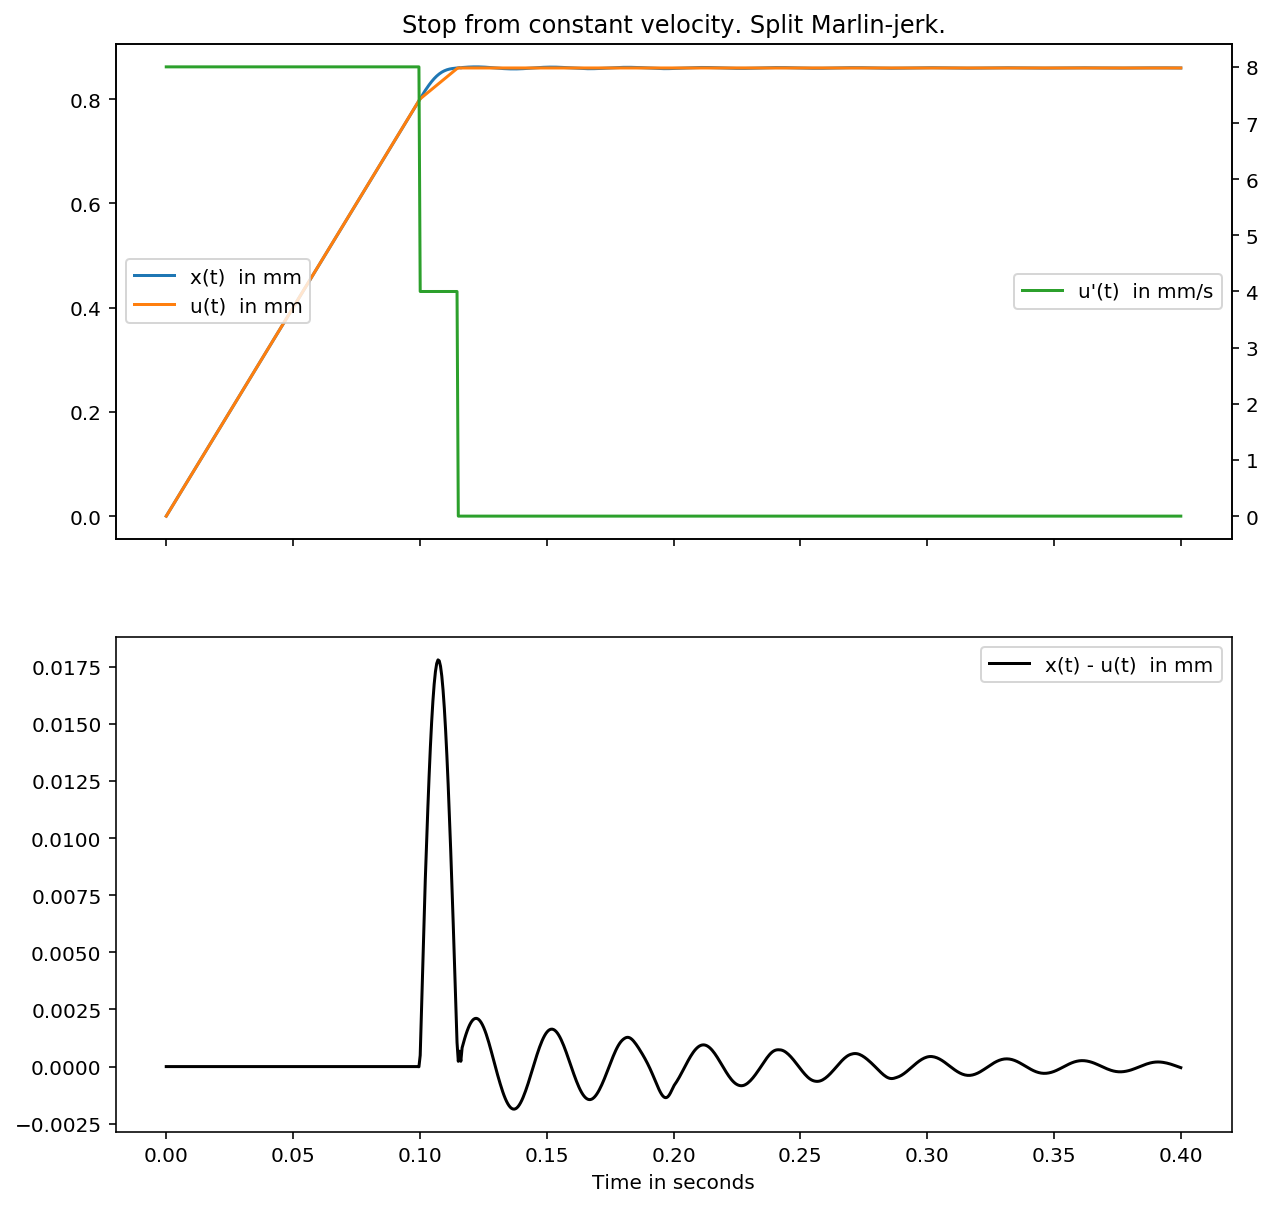

In [7]:
u0 = 0
v0 = 0.008
T1 = 0.1
dT = period/2
def fu(t):
    # constant speed v0, then douple speedjerk at t = T1 and t = T1 + dT
    if t<T1:
        return [u0 + v0*t, v0]
    elif t<T1 + dT:
        return [u0 + v0*T1 + v0/2 * (t-T1), v0/2]
    else:
        return [u0 + v0*T1 + v0/2 * dT, 0]

plotfun(fu, [0.,v0], 'Stop from constant velocity. Split Marlin-jerk.')

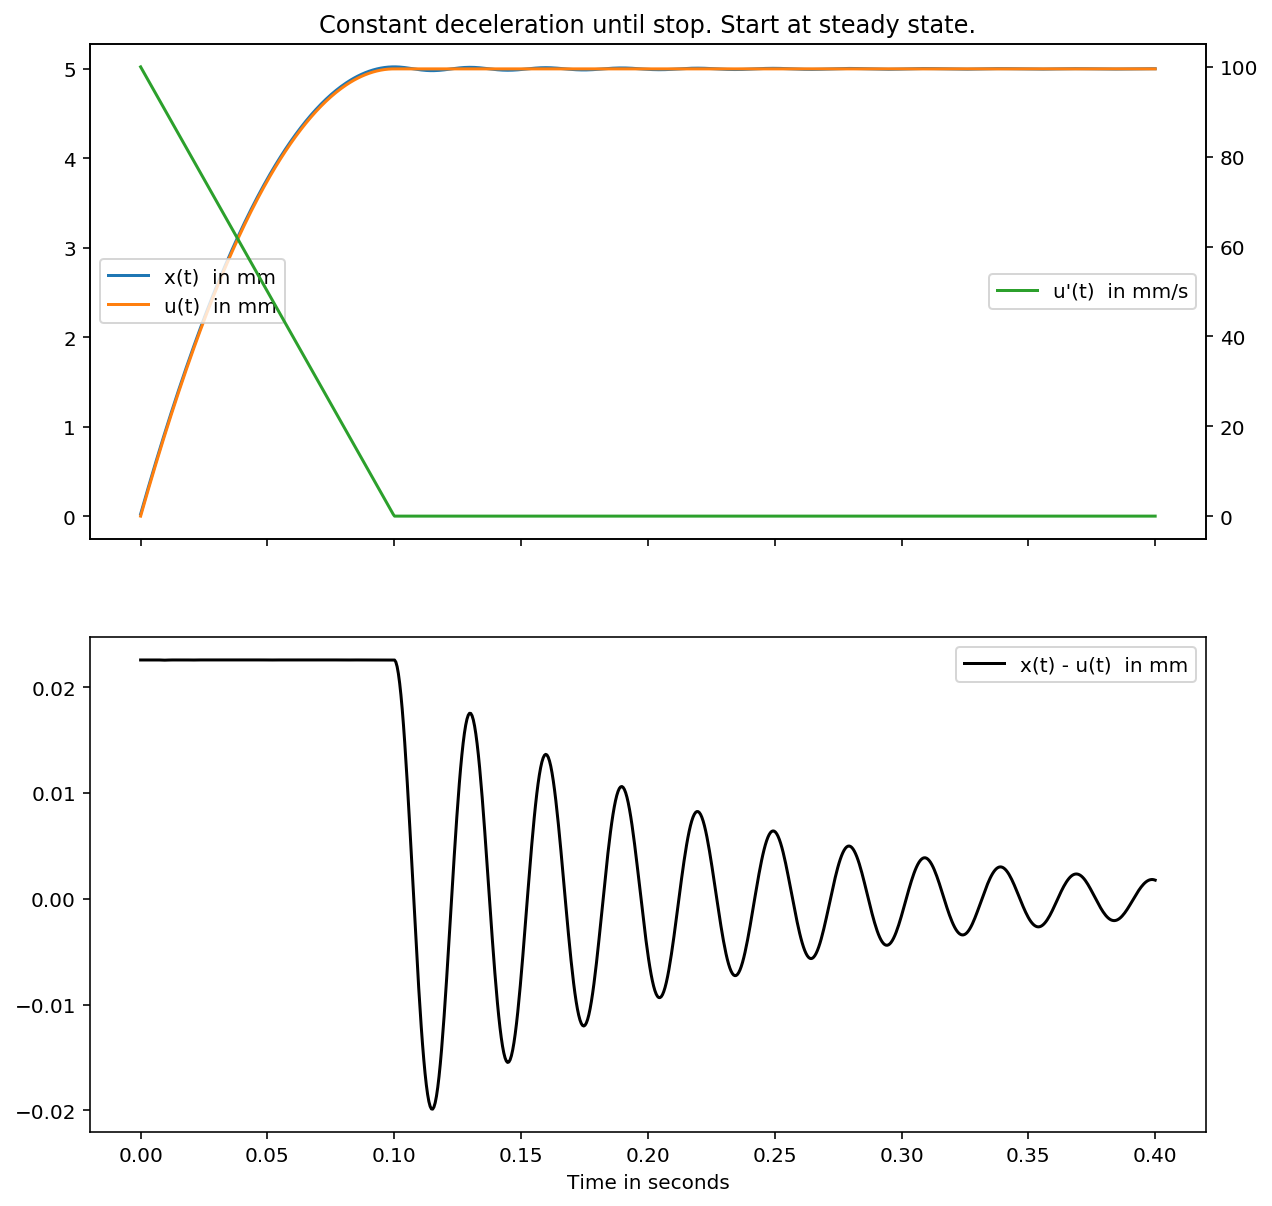

In [8]:
u0 = 0.
v0 = 0.1
a = -1.

T = - v0 / a

def fu(t):
    # constant deceleration a, then stop at t = T
    if t<T:
        return [u0+v0*t + 0.5*a*t*t , v0 + a*t]
    else:
        return [u0+v0*T + 0.5*a*T*T, v0 + a*T]

plotfun(fu, [-a/omega2,v0], 'Constant deceleration until stop. Start at steady state.')

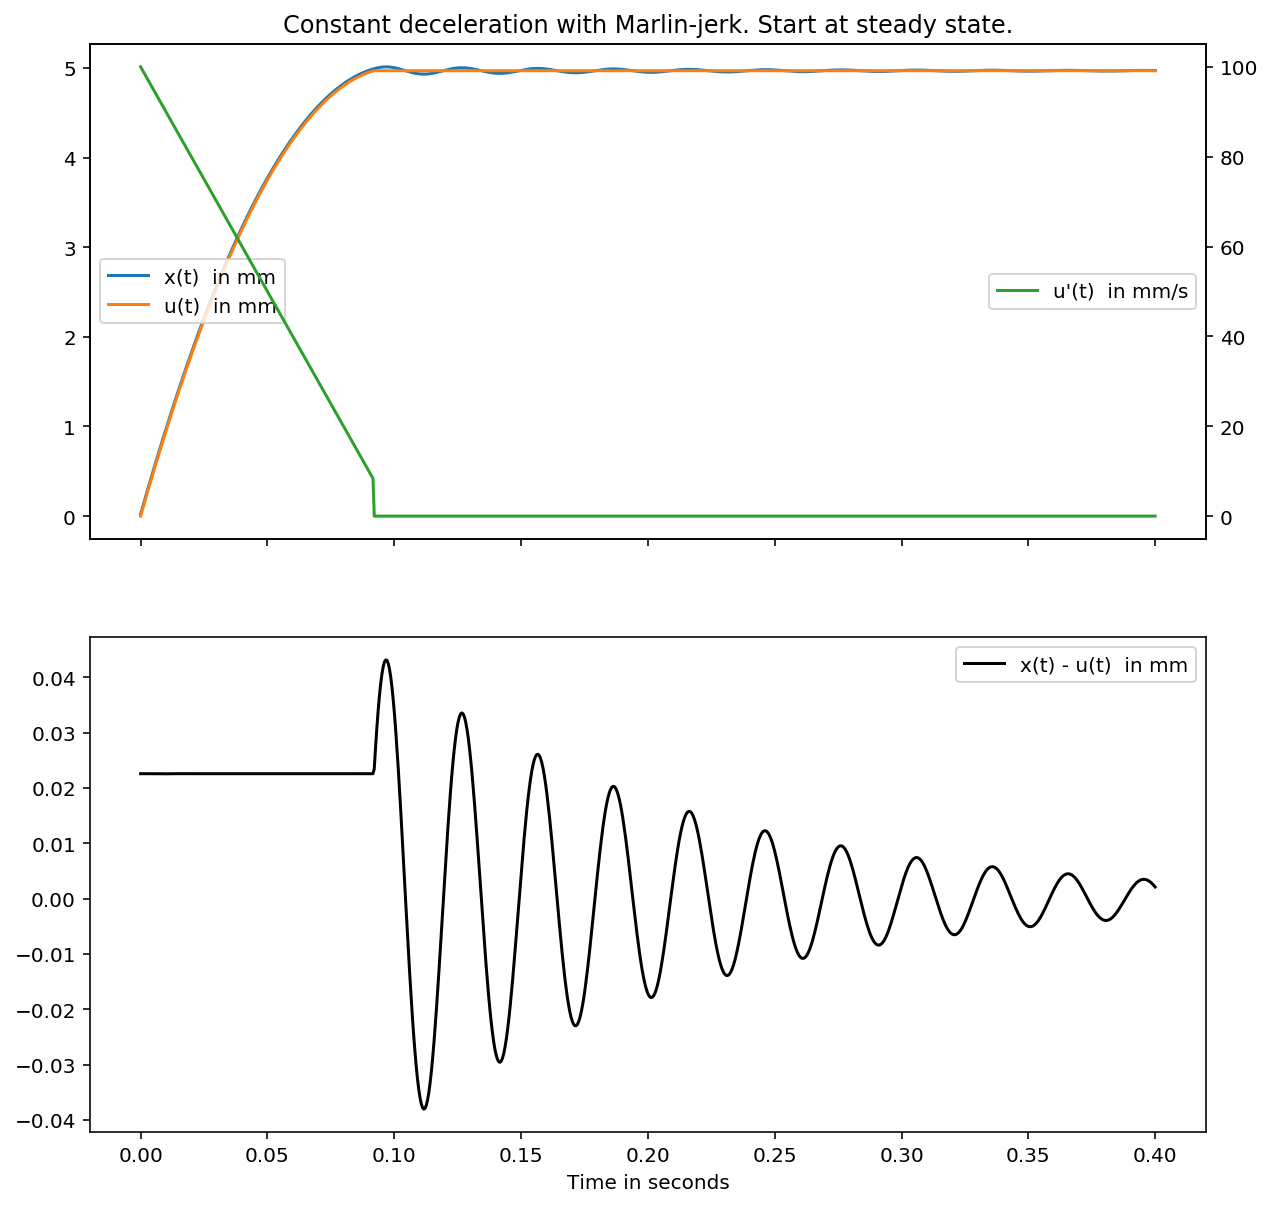

In [9]:
u0 = 0.
v0 = 0.1
Mj = 0.008
a = -1.

T1 = -(v0-Mj)/a

def fu(t):
    # constant deceleration a, then speedjerk at t = T1
    if t<T1:
        return [u0+v0*t + 0.5*a*t**2 , v0 + a*t]
    else:
        return [u0+v0*T1 + 0.5*a*T1**2, 0]

plotfun(fu, [-a/omega2,v0], 'Constant deceleration with Marlin-jerk. Start at steady state.')

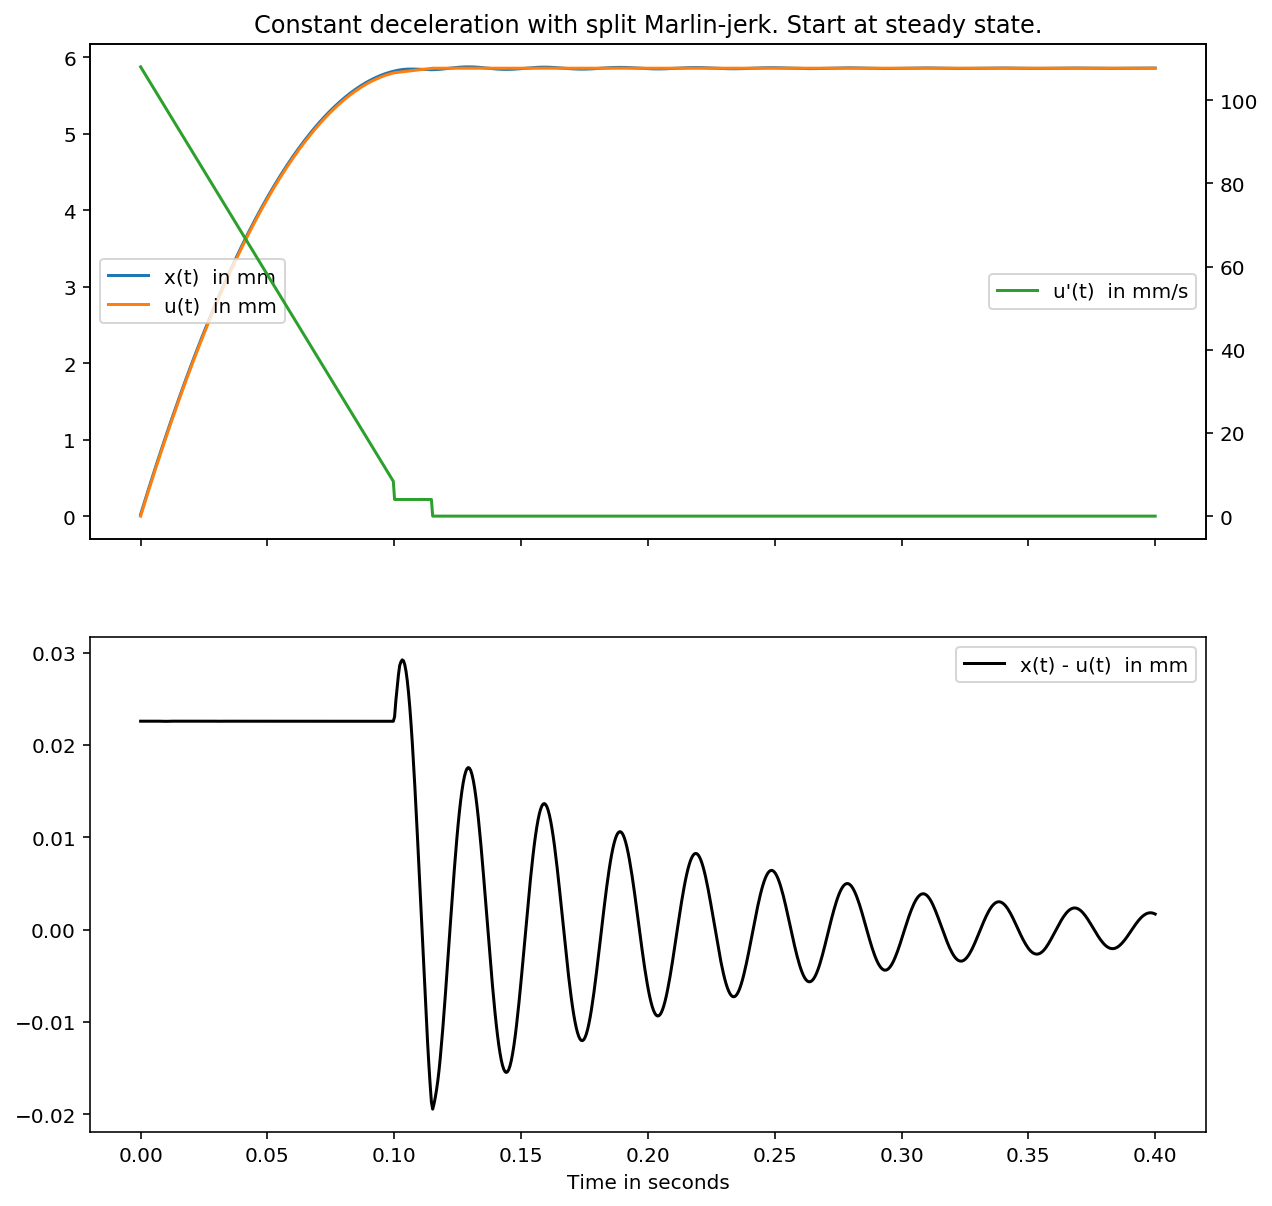

In [10]:
u0 = 0
v1 = 0.008
a = -1
T1 = .1

v0 = v1  - a*T1

dT = period/2
def fu(t):
    # constant deceleration a, then douple speedjerk at t = T1 and t = T1 + dT
    if t<T1:
        return [u0+v0*t + 0.5*a*t*t , v0 + a*t]
    elif t<T1 + dT:
        return [u0 + v0*T1 + 0.5*a*T1**2 + v1/2 * (t-T1), v1/2]
    else:
        return [u0 + v0*T1 + 0.5*a*T1**2 + v1/2 * dT, 0]

plotfun(fu, [-a/omega2,v0],  'Constant deceleration with split Marlin-jerk. Start at steady state.')

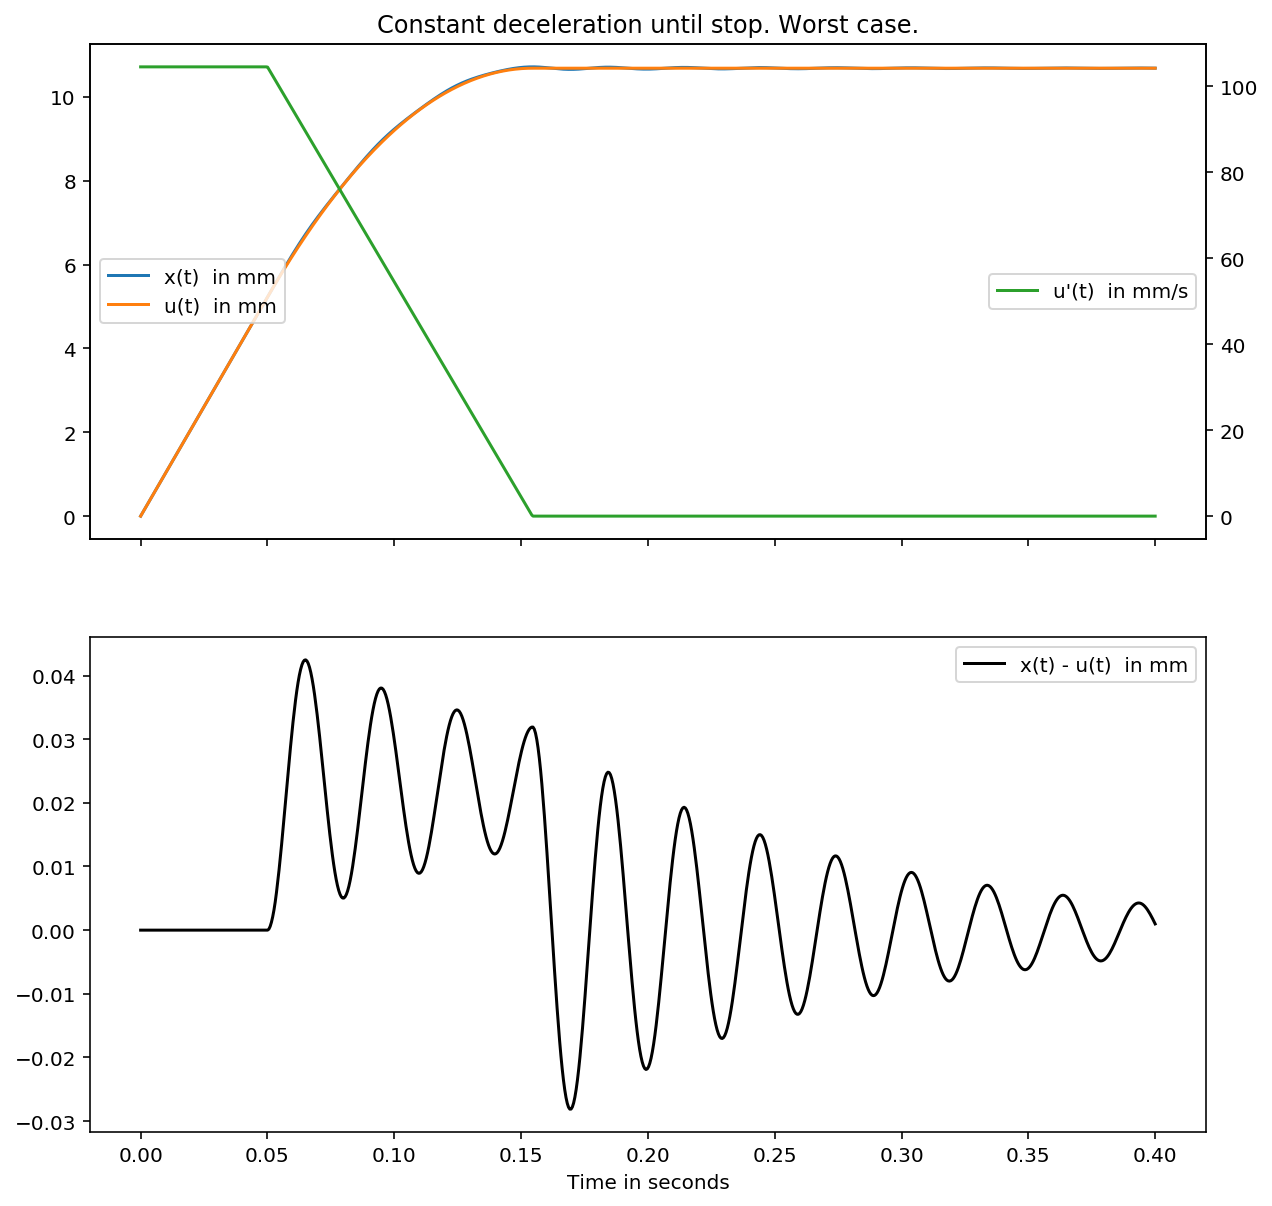

In [11]:
a = -1.

T0 = 0.05
v0_target = 0.1

# worst case: deceleration takes n+0.5 vibration periods (ignore damping)
dT_target = - v0_target / a
nPeriods_target = dT_target / period
nPeriods = 0.5 + round(nPeriods_target-0.5)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]

plotfun(fu, [0,v0], 'Constant deceleration until stop. Worst case.')

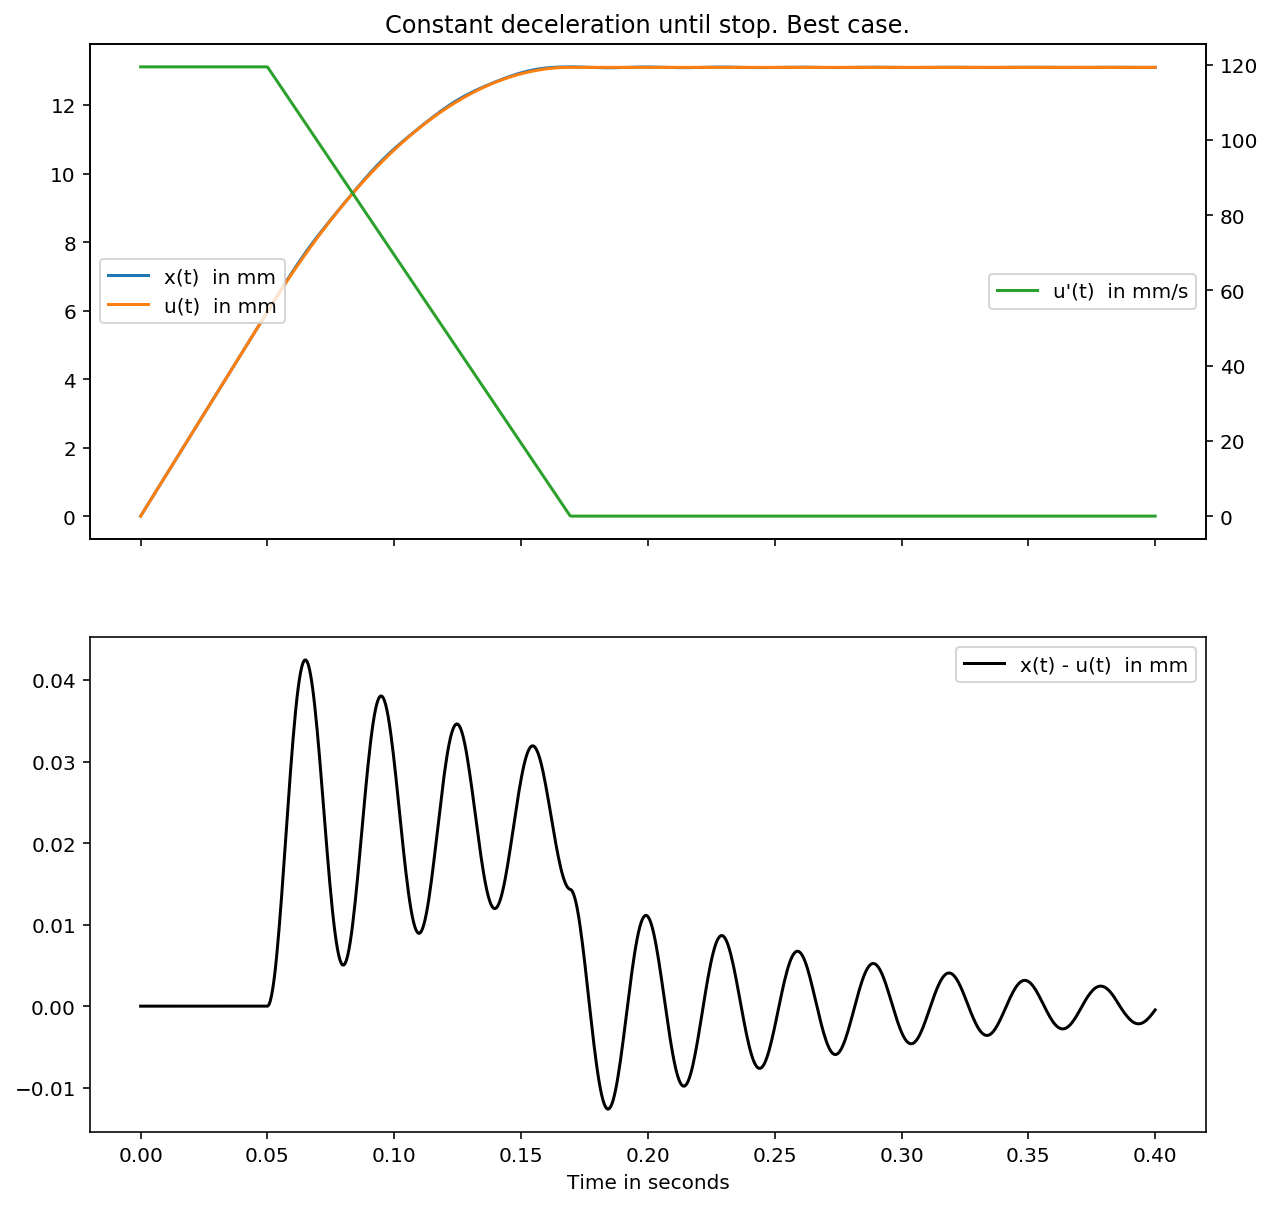

In [12]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# best case: deceleration takes n vibration periods (ignore damping)
dT_target = - v0_target / a
nPeriods_target = dT_target / period
nPeriods = np.ceil(nPeriods_target)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]

plotfun(fu, [0,v0], 'Constant deceleration until stop. Best case.')

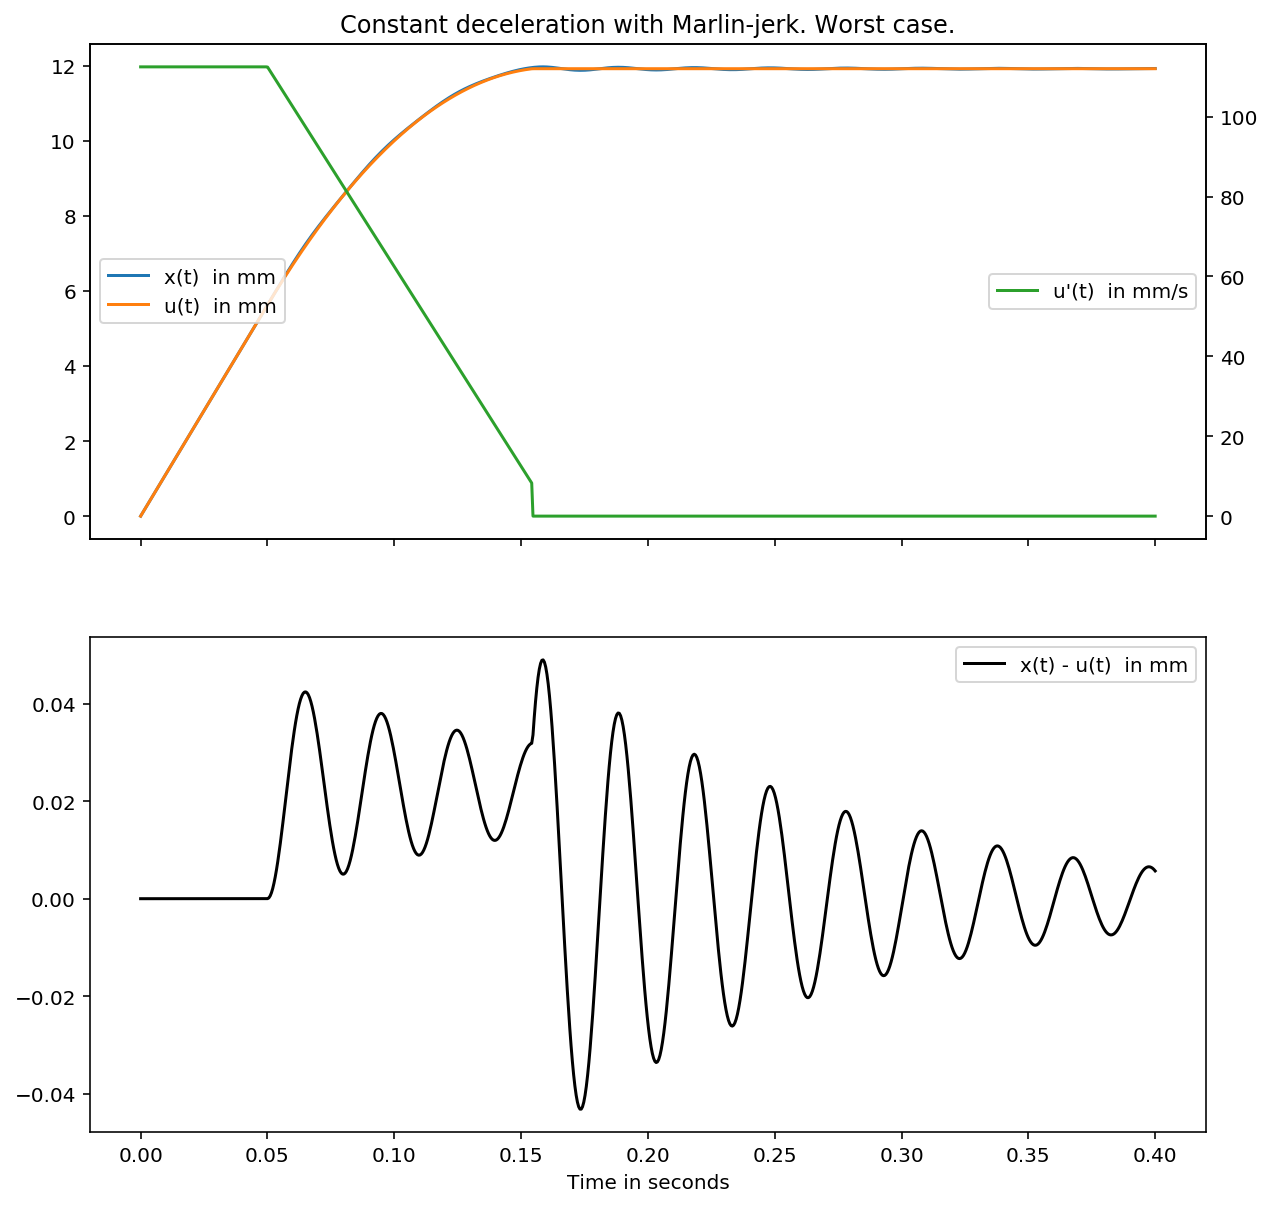

In [13]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# worst case: deceleration takes n+0.5 vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = 0.5 + round(nPeriods_target-0.5)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]

plotfun(fu, [0,v0], 'Constant deceleration with Marlin-jerk. Worst case.')

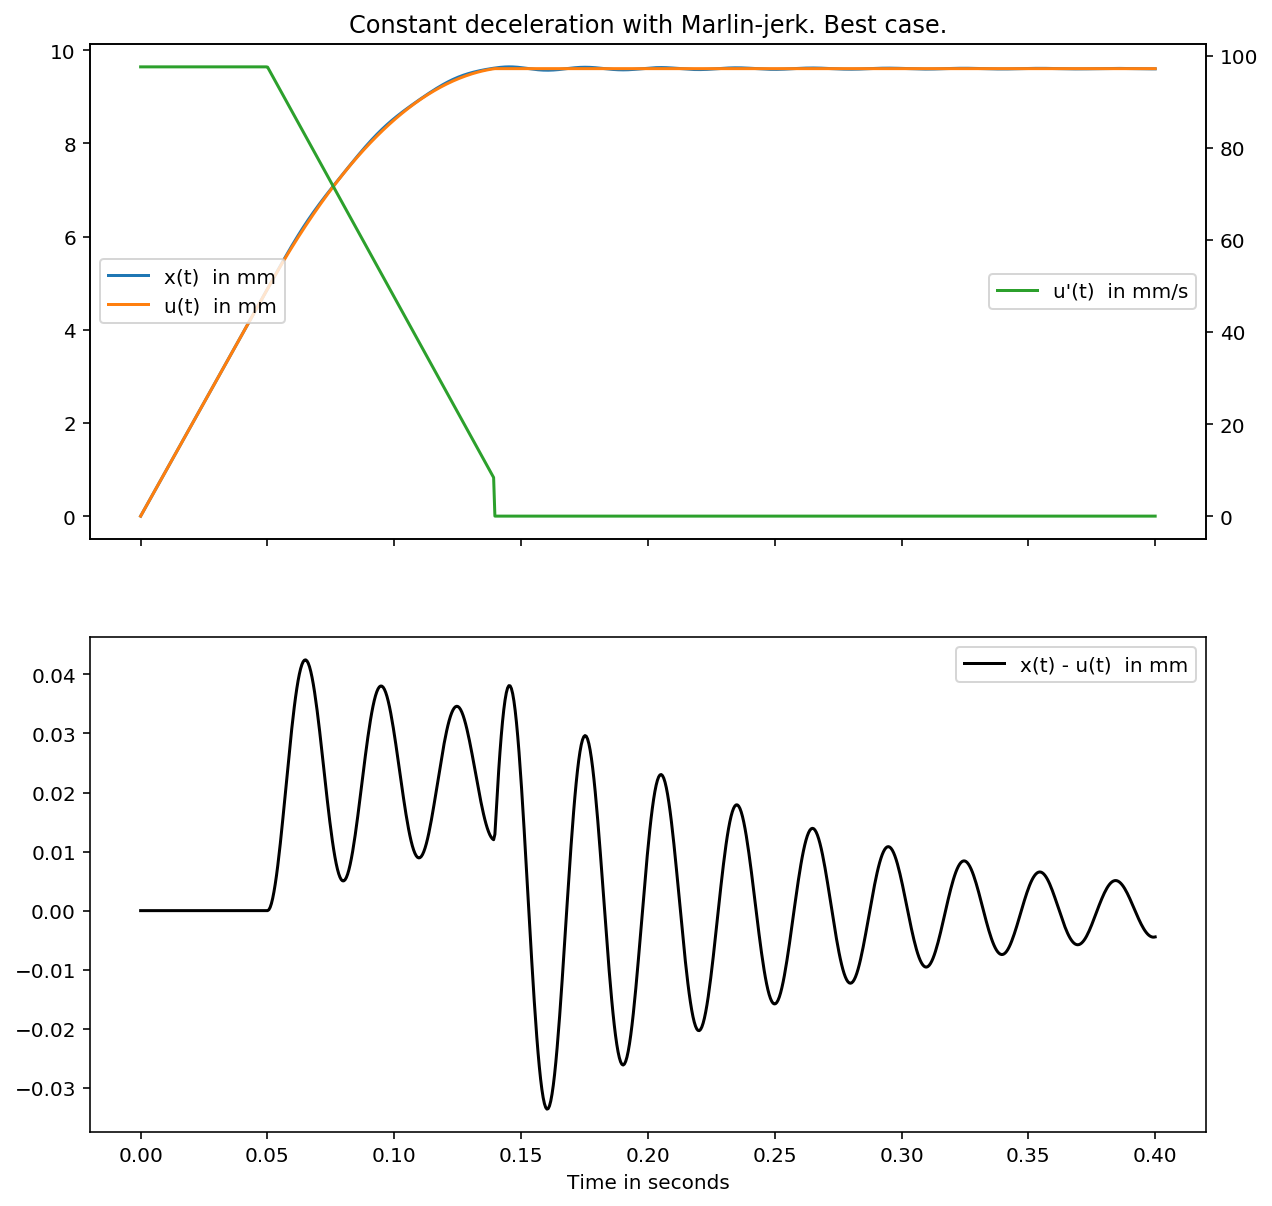

In [14]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# best case: deceleration takes n vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = round(nPeriods_target)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]

plotfun(fu, [0,v0], 'Constant deceleration with Marlin-jerk. Best case.')

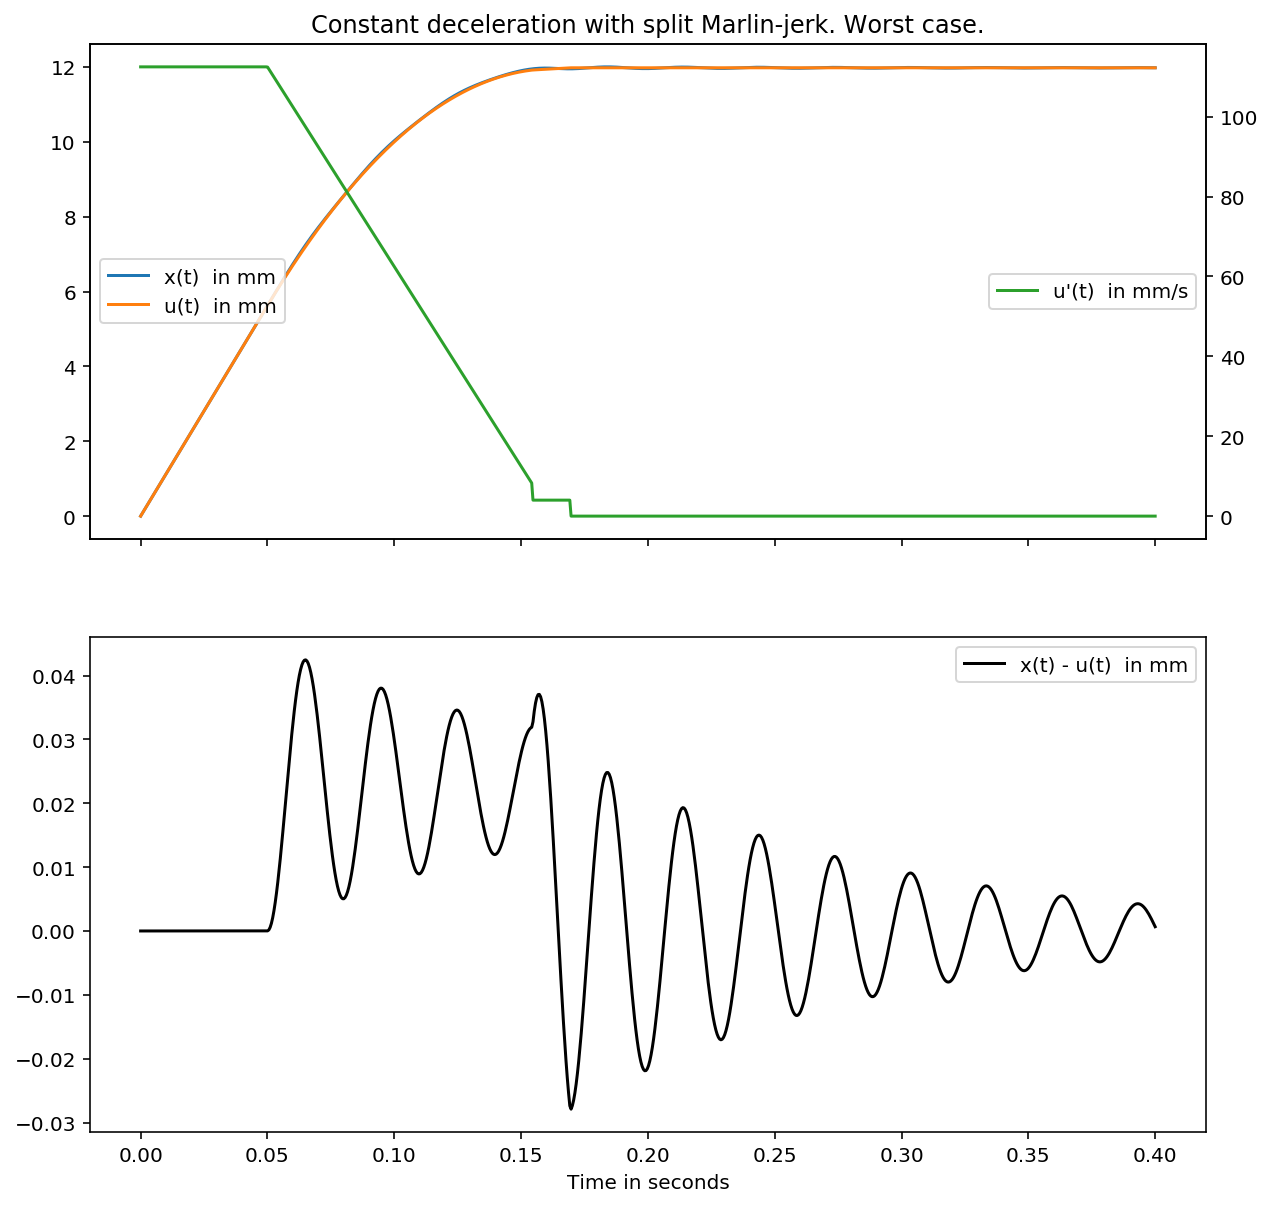

In [15]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# worst case: deceleration takes n+0.5 vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = 0.5 + round(nPeriods_target-0.5)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

T2 = T1 + period/2

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    elif t<T2:
        return [u0+v0*dT + 0.5*a*dT**2 + (t-T1)*Mj/2,Mj/2]
    else:
        return [u0+v0*dT + 0.5*a*dT**2 + period*Mj/4, 0]

plotfun(fu, [0,v0], 'Constant deceleration with split Marlin-jerk. Worst case.')

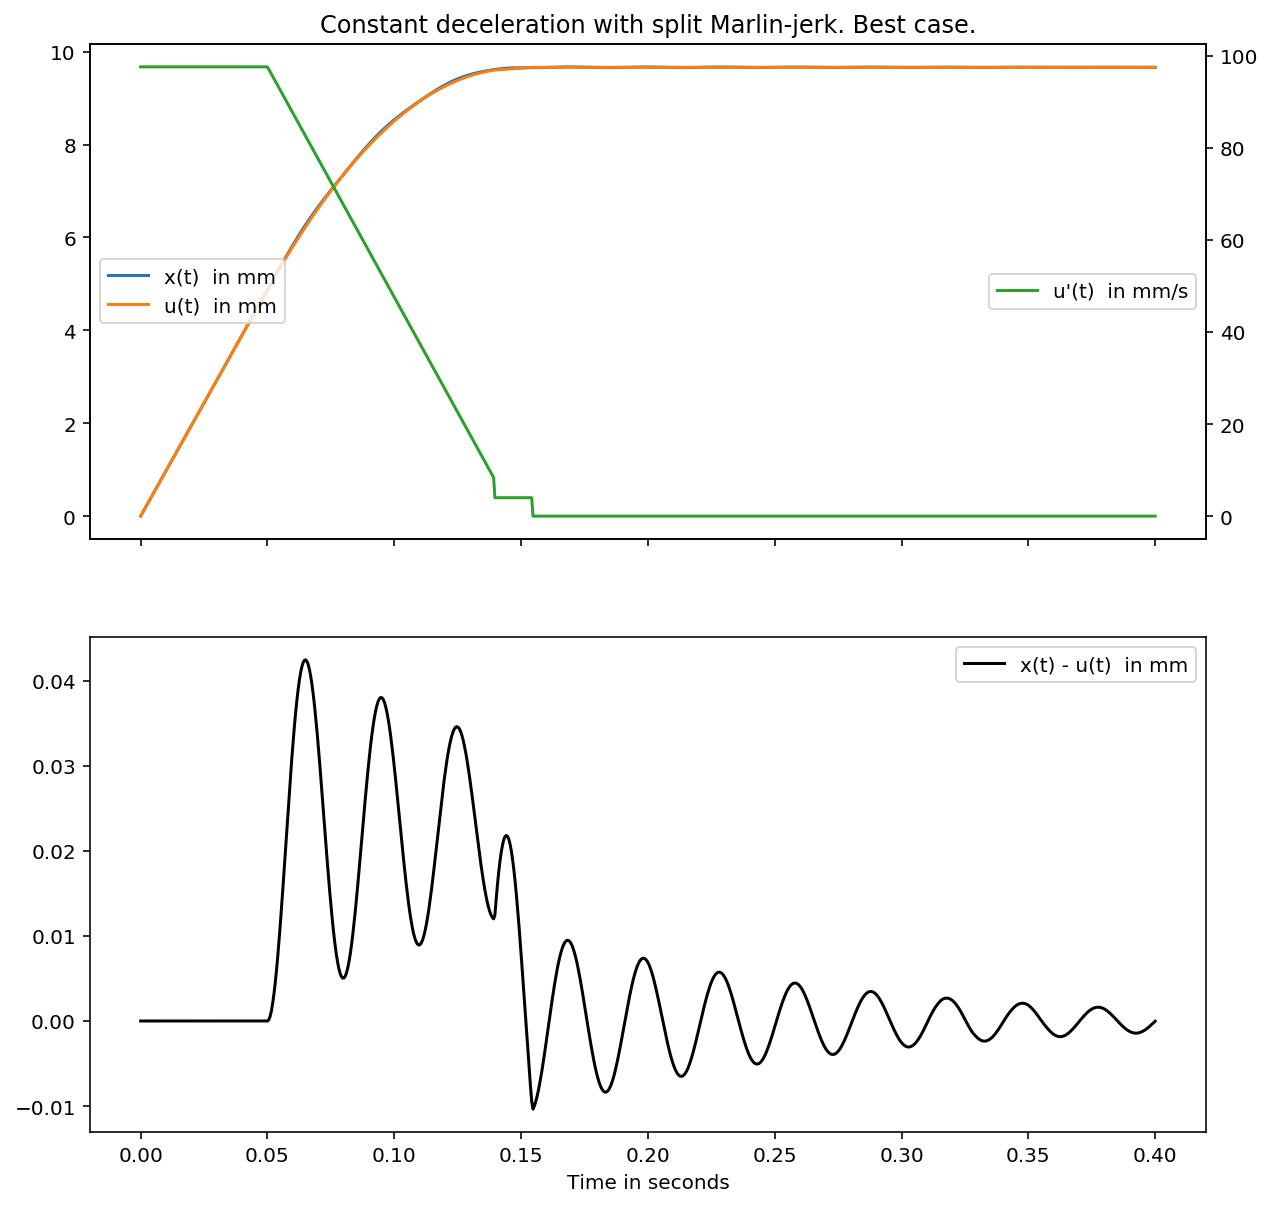

In [16]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# best case: deceleration takes n vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = round(nPeriods_target)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

T2 = T1 + period/2

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    elif t<T2:
        return [u0+v0*dT + 0.5*a*dT**2 + (t-T1)*Mj/2,Mj/2]
    else:
        return [u0+v0*dT + 0.5*a*dT**2 + period*Mj/4, 0]

plotfun(fu, [0,v0], 'Constant deceleration with split Marlin-jerk. Best case.')

Jerk-limited deceleration 
=========================

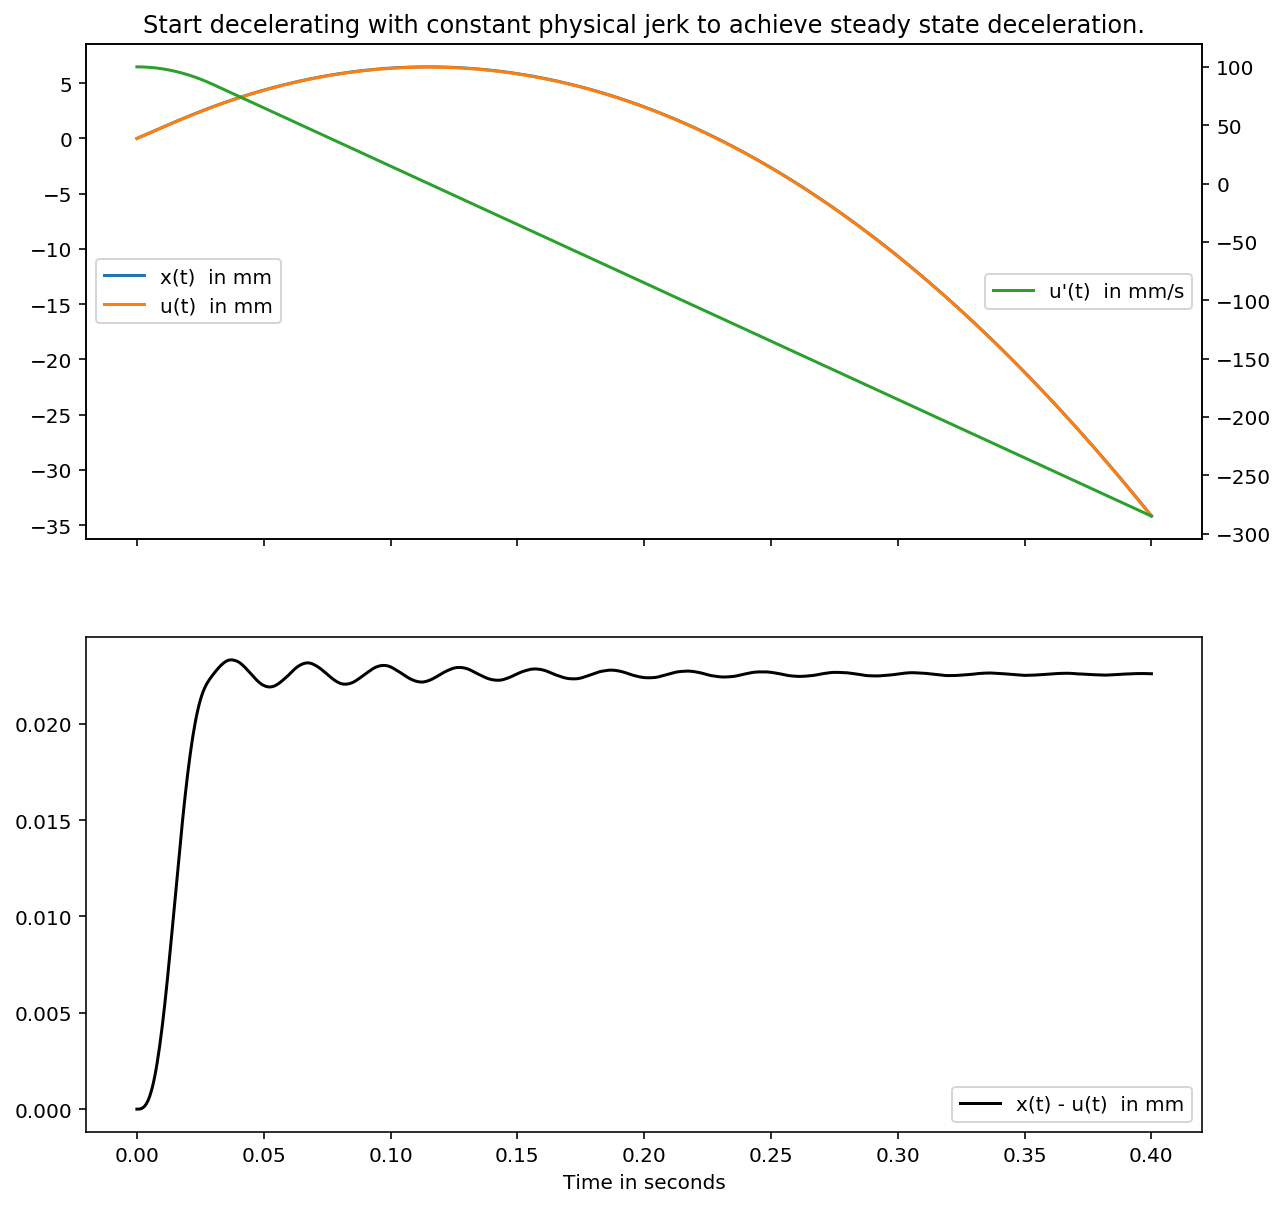

In [17]:
u0 = 0.
v0 = 0.1
a = -1.
j = -a / period

T1 = - a/j

v1 = v0 - 0.5 * a**2 / j
u1 = u0 + v0*T1 - j/6*T1**3


def fu(t):
    # start deceleration with constant physical jerk
    if t<T1:
        return [u0 + v0*t - j/6*t**3 , v0 - j/2*t**2]
    else:
        return [u1 + v1*(t-T1) + a/2*(t-T1)**2, v1 + a*(t-T1)]

plotfun(fu, [0.,v0], 'Start decelerating with constant physical jerk to achieve steady state deceleration.')

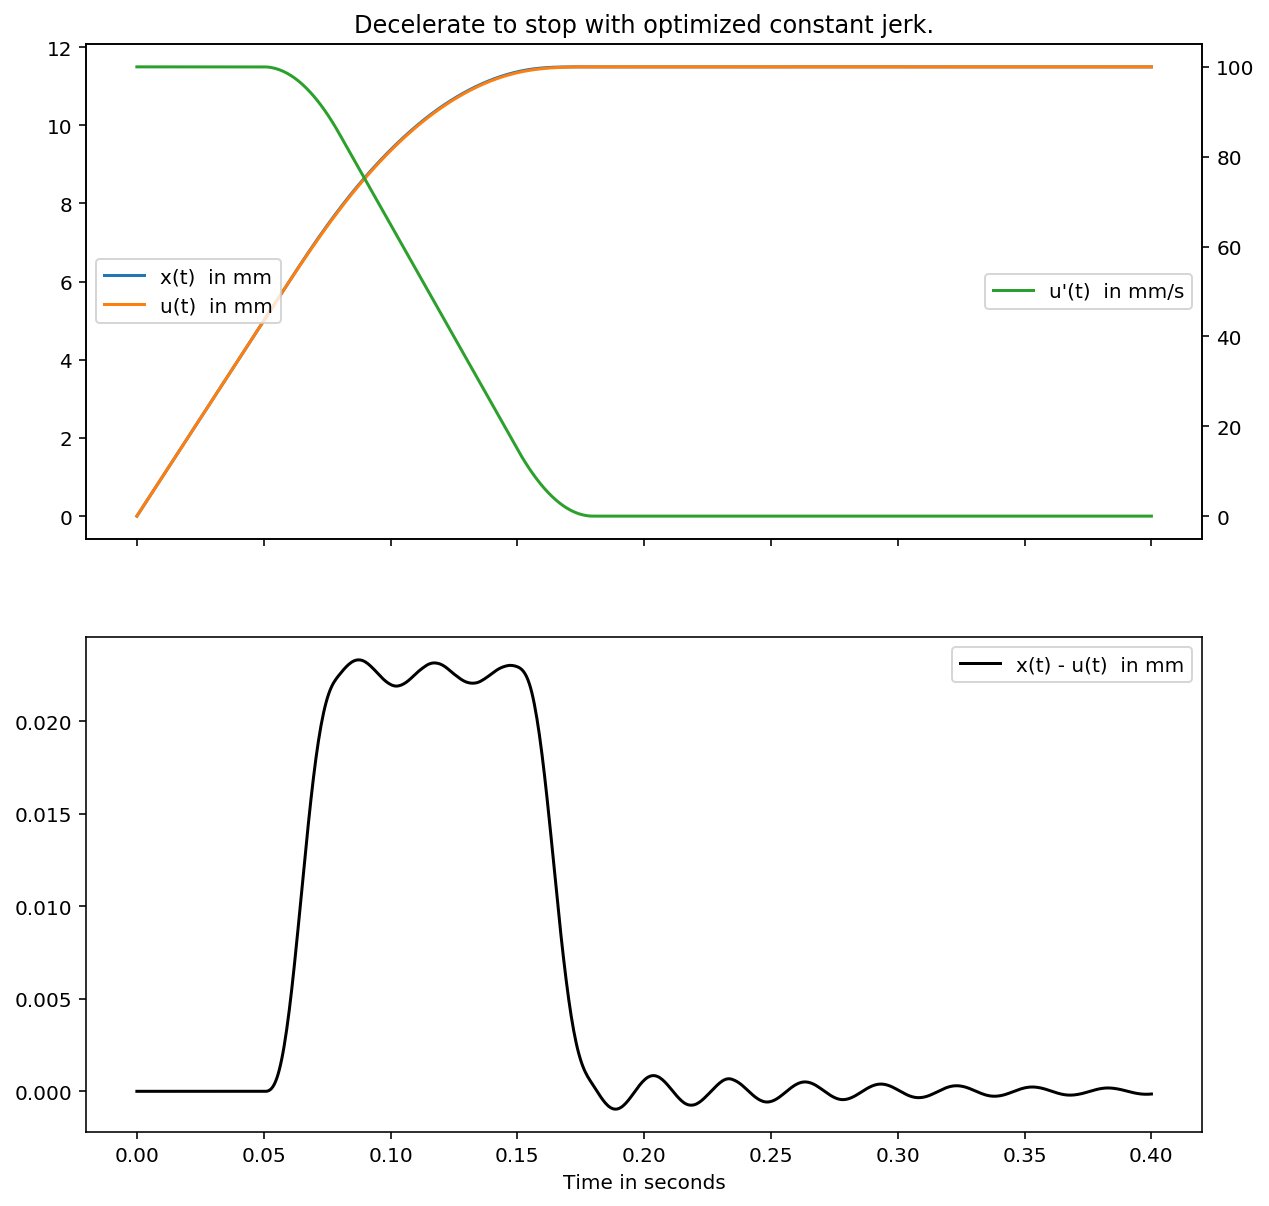

In [18]:
v0 = 0.1
a = -1.
j = -a / period
T0 = 0.05

u0 = 0.05 * v0

T1 = - a/j + T0
v1 = v0 - 0.5 * a**2 / j
u1 = u0 + v0*(T1-T0) - j/6*(T1-T0)**3

v2 = 0.5 * a**2 / j
T2 = T1 + (v2-v1) / a
u2 = u1 + v1*(T2-T1) + 0.5*a*(T2-T1)**2

T3 = T2 - a/j
u3 = u2 - j/6*(a/j)**3


def fu(t):
    # decelerate to stop with optimized constant jerk
    if t<T0:
        return [v0*t, v0]
    elif t<T1:
        return [u0 + v0*(t-T0) - j/6*(t-T0)**3 , v0 - j/2*(t-T0)**2]
    elif t<T2:
        return [u1 + v1*(t-T1) + a/2*(t-T1)**2, v1 + a*(t-T1)]
    elif t<T3:
        return [u3 + j/6*(t-T3)**3, j/2 * (t-T3)**2]
    else:
        return [u3,0]

plotfun(fu, [0.,v0], 'Decelerate to stop with optimized constant jerk.')

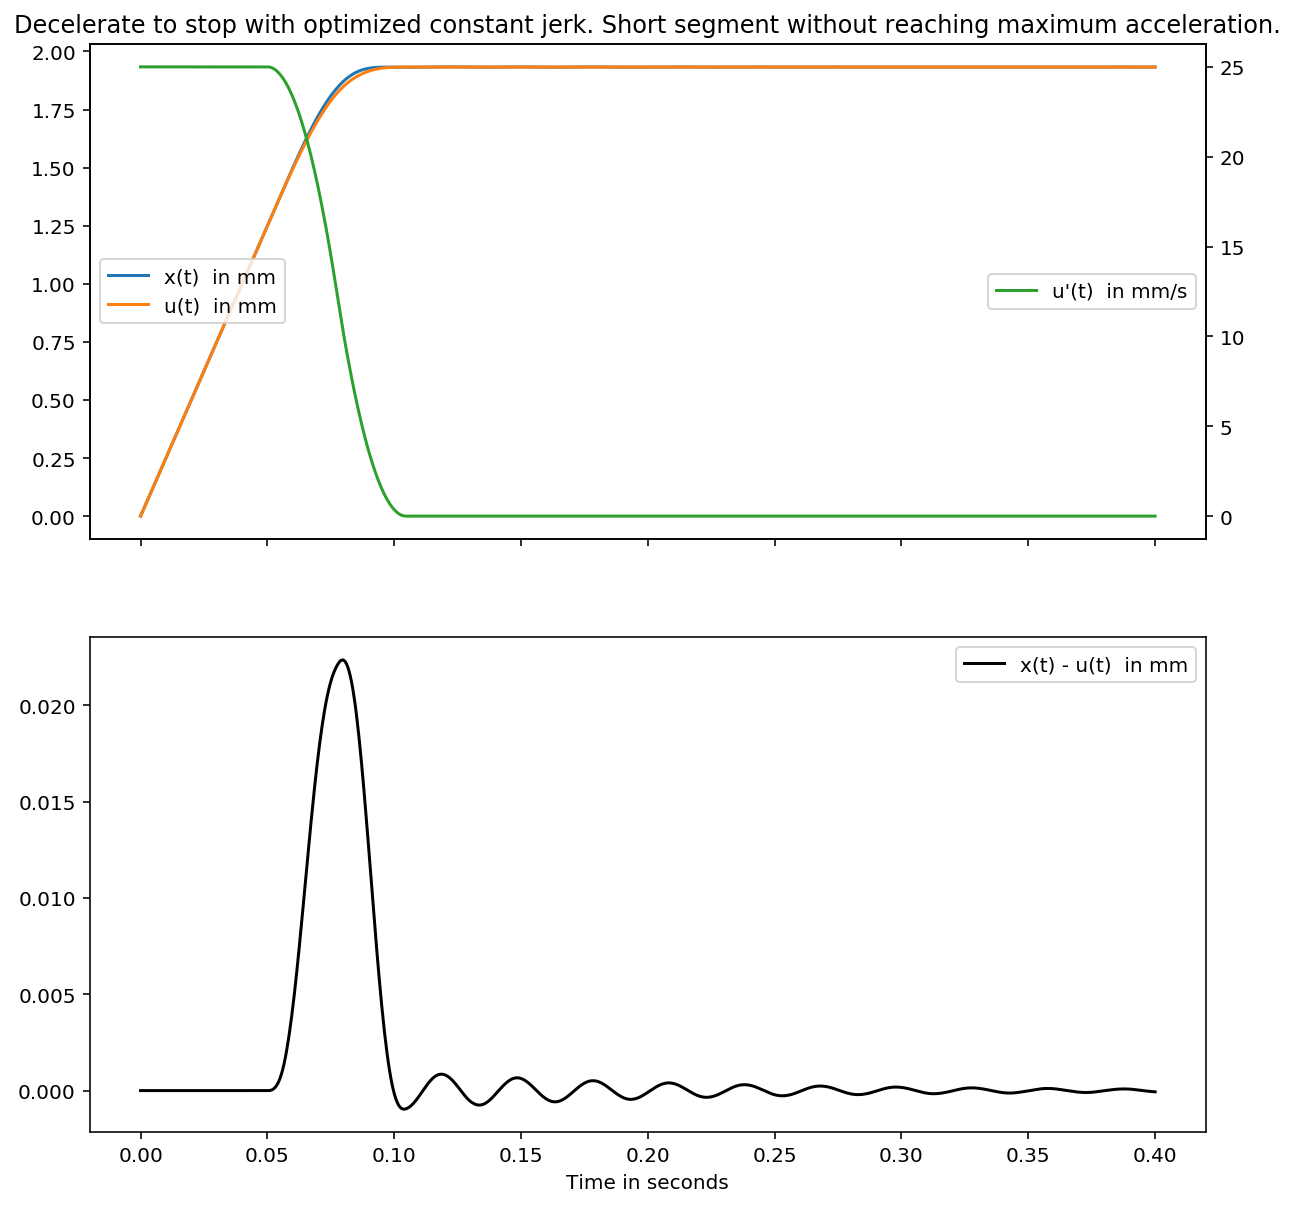

In [19]:
v0 = 0.025
a = -1. # not actually reached
j = -a / period
T0 = 0.05

u0 = 0.05 * v0

dT = np.sqrt(v0/j)
T1 = T0 + dT

T2 = T1 +dT
u2 = u0 + v0 * dT - j/6*(dT)**3 + j/6*(dT)**3


def fu(t):
    # decelerate to stop with optimized constant jerk, no constant acceleration phase
    if t<T0:
        return [v0*t, v0]
    elif t<T1:
        return [u0 + v0*(t-T0) - j/6*(t-T0)**3 , v0 - j/2*(t-T0)**2]
    elif t<T2:
        return [u2 + j/6*(t-T2)**3, j/2 * (t-T2)**2]
    else:
        return [u2,0]

plotfun(fu, [0.,v0], 'Decelerate to stop with optimized constant jerk. Short segment without reaching maximum acceleration.')

ZV shaping
==========

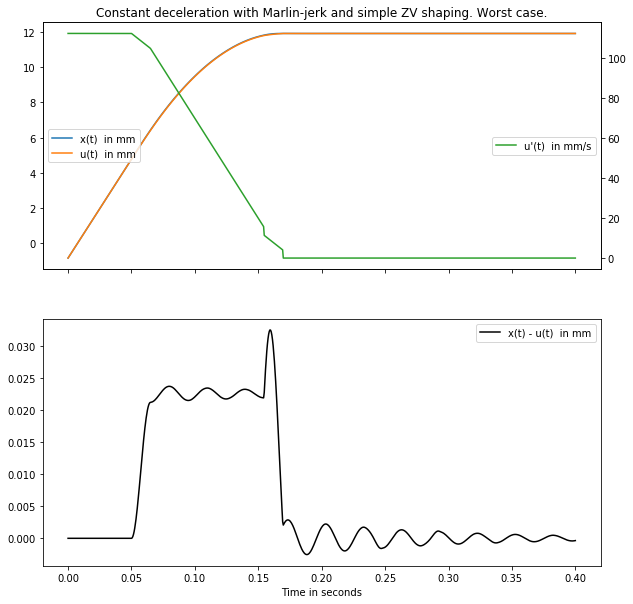

In [17]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# worst case: deceleration takes n+0.5 vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = 0.5 + round(nPeriods_target-0.5)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]
    
def fu2(t):
    (x1,v1) = fu(t)
    (x2,v2) = fu(t-period/2)
    return [0.5*(x1+x2),0.5*(v1+v2)]

plotfun(fu2, fu2(0.0), 'Constant deceleration with Marlin-jerk and simple ZV shaping. Worst case.')

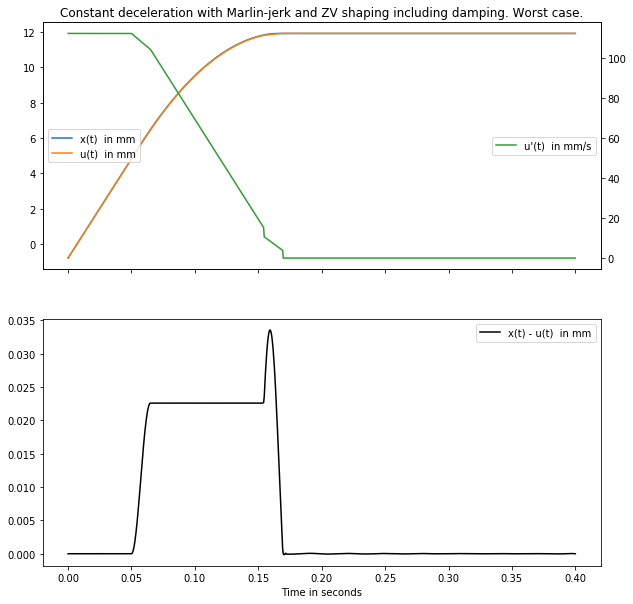

In [16]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# worst case: deceleration takes n+0.5 vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = 0.5 + round(nPeriods_target-0.5)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]

Q =   np.exp(-D*np.pi * dPeriod/period)
A1 = 1./(1.+Q)
A2 = Q/(1.+Q)

    
def fu2(t):
    (x1,v1) = fu(t)
    (x2,v2) = fu(t-dPeriod/2)
    return [A1*x1 + A2*x2,A1*v1 + A2*v2]

plotfun(fu2, fu2(0.0), 'Constant deceleration with Marlin-jerk and ZV shaping including damping. Worst case.')

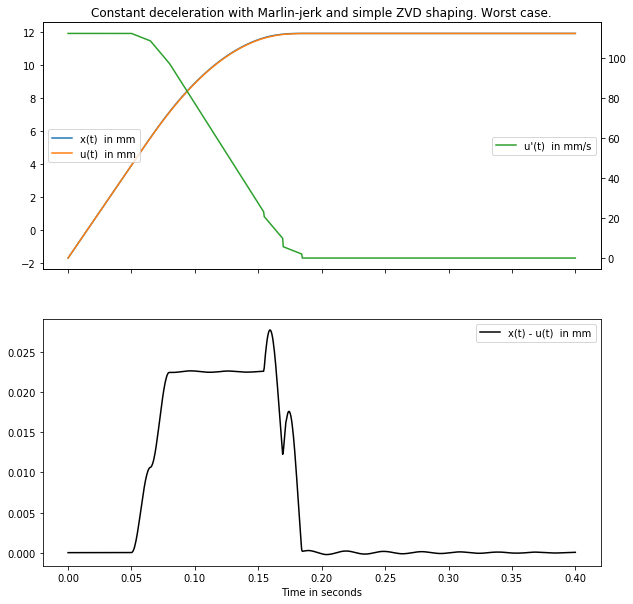

In [18]:
a = -1.
Mj = 0.008
T0 = 0.05
v0_target = 0.1

# worst case: deceleration takes n+0.5 vibration periods (ignore damping)
dT_target = - (v0_target - Mj) / a
nPeriods_target = dT_target / period
nPeriods = 0.5 + round(nPeriods_target-0.5)
dT = nPeriods * period
T1 = T0 + dT
v0 = - dT * a + Mj
u0 = v0 * T0

def fu(t):
    # constant speed until T0, constant deceleration a until T1, then stop
    if t<T0:
        return [v0*t , v0]
    elif t<T1:
        return [u0+v0*(t-T0) + 0.5*a*(t-T0)**2 , v0 + a*(t-T0)]
    else:
        return [u0+v0*dT + 0.5*a*dT**2, 0]
    
def fu2(t):
    (x1,v1) = fu(t)
    (x2,v2) = fu(t-period/2)
    (x3,v3) = fu(t-period)
    return [(x1+2*x2+x3)/4,(v1+2*v2+v3)/4]

plotfun(fu2, fu2(0.0), 'Constant deceleration with Marlin-jerk and simple ZVD shaping. Worst case.')